In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install forgebox

     |████████████████████████████████| 51 kB 281 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from forgebox.imports import *
from joblib import Parallel, delayed

In [4]:
INPUT = Path('/kaggle/input')
DATA = INPUT/"siim-isic-melanoma-classification"
TRAIN = DATA/"jpeg"/'train'
TEST  = DATA/"jpeg"/'test'

In [5]:
DATA.ls()

['train',
 'test',
 'test.csv',
 'sample_submission.csv',
 'jpeg',
 'train.csv',
 'tfrecords']

In [6]:
TRAIN.ls()[:5]

['ISIC_5749706.jpg',
 'ISIC_9038210.jpg',
 'ISIC_9932789.jpg',
 'ISIC_3649363.jpg',
 'ISIC_6591185.jpg']

In [7]:
TEST.ls()[:5]

['ISIC_6024601.jpg',
 'ISIC_1521467.jpg',
 'ISIC_7405314.jpg',
 'ISIC_1667159.jpg',
 'ISIC_5176953.jpg']

In [8]:
def open_img(path,parent = TRAIN):
    return Image.open(parent/path).convert('RGB')

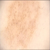

In [9]:
open_img('ISIC_2679975.jpg').resize((50,50))

In [10]:
# train_meta_df = pd.DataFrame(dict(fname = TRAIN.ls()))
# test_meta_df = pd.DataFrame(dict(fname = TEST.ls()))

# train_meta_df['img_size'] = train_meta_df.fname.apply(lambda fname: open_img(fname).size)

# test_meta_df['img_size'] = test_meta_df.fname.apply(lambda fname: open_img(fname,parent=TEST).size)

# train_meta_df.vc("img_size").head(20)

# test_meta_df.vc("img_size").head(20)

```
img_size
(6000, 4000)	14703
(1872, 1053)	7534
(640, 480)	4147
(5184, 3456)	3418
(3264, 2448)	1483
(4288, 2848)	729
(2592, 1936)	674
(3888, 2592)	140
(4032, 3024)	84
(2317, 2317)	29
(2848, 4288)	17
(3456, 5184)	16
(4608, 3072)	10
(1761, 1761)	7
(1775, 1775)	7
(2329, 2329)	6
(1763, 1763)	6
(1769, 1769)	5
(1773, 1773)	4
(3872, 2592)	4
```


```
	img_size
(6000, 4000)	14703
(1872, 1053)	7534
(640, 480)	4147
(5184, 3456)	3418
(3264, 2448)	1483
(4288, 2848)	729
(2592, 1936)	674
(3888, 2592)	140
(4032, 3024)	84
(2317, 2317)	29
(2848, 4288)	17
(3456, 5184)	16
(4608, 3072)	10
(1761, 1761)	7
(1775, 1775)	7
(2329, 2329)	6
(1763, 1763)	6
(1769, 1769)	5
(1773, 1773)	4
(3872, 2592)	4
```

In [11]:
# img.resize((60,40))

Cropping with (left, upper, right, lower)

In [12]:
def proper_size(img):
    w,h = img.size
    if h>w:
        img = img.transpose(Image.ROTATE_90)
    check = False
    while check == False:
        if min(w,h)>1599:
            img = img.resize((w//2,h//2))
        if min(w,h)<256:
            img = img.resize((w*2,h*2))
            
        w,h = img.size
        check = True
    return img

In [13]:
def find_center(img,size = 256):
    w,h = img.size
    left = w//2-size//2
    upper = h//2-size//2
    right = left+size
    lower = upper+size
    return img.crop((left, upper, right, lower))

In [14]:
from random import choice

In [15]:
def find_ratio(img,size = 256,ratio = .3):
    w,h = img.size
    h2 = int(h*ratio)
    upper = (h-h2)//2
    lower = upper+h2
    
    w2 = int(w*ratio)
    wpad = (w-w2)//2
    start = choice(list(range(max(1,w2-h2))))
    left = wpad+start
    right = left+h2

    return img.crop((left, upper, right, lower)).resize((size,size))

In [16]:
def combine_4in1(*imgs,size = 256):
    dst = Image.new('RGB', (size*2,size*2))
    dst.paste(imgs[0], (0, 0))
    dst.paste(imgs[1], (0, size))
    dst.paste(imgs[2], (size, 0))
    dst.paste(imgs[3], (size, size))
    return dst

In [17]:
def different_scale_crop(img,size=512):
    img = proper_size(img)
    return combine_4in1(*map(lambda i:find_ratio(img,size=size//2,ratio = 1-2*(i/10)),range(1,5)))

In [18]:
img = different_scale_crop(open_img(TRAIN.ls()[0]),size = 512)

In [19]:
HOME = Path(".")

In [20]:
TRAIN_SAVE = HOME/"img/train"
TEST_SAVE = HOME/"img/test"

In [21]:
!mkdir -p {TRAIN_SAVE}
!mkdir -p {TEST_SAVE}

In [22]:

train_files = TRAIN.ls()
def process_file_train(fname):
    img = open_img(fname,parent = TRAIN)
    img = different_scale_crop(img,size = 512)
    newname = fname.split(".")[0]+".jpg"
    img.save(TRAIN_SAVE/f"{newname}")

In [23]:
Parallel(n_jobs=8)(delayed(process_file_test)(fname) for fname in test_files)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 ...]

In [26]:
!ls -l {TRAIN_SAVE}|wc -l

33127


In [27]:
!ls -l {TEST_SAVE}|wc -l

10983


In [28]:
# different_scale_crop(open_img(TRAIN.ls()[1]),size = 512)

In [29]:
# different_scale_crop(open_img(TRAIN.ls()[2]),size = 512)

In [30]:
# find_ratio(img,ratio = .4)

In [31]:
!tar -czvf train_data.tar.gz {TRAIN_SAVE} > /dev/null

In [32]:
!rm -rf {TRAIN_SAVE}

In [33]:
!tar -czvf test_data.tar.gz {TEST_SAVE} > /dev/null

In [34]:
!rm -rf {TEST_SAVE}